<h1>  Assignment </h1>

1.Instead of using 10K users and 1K movies to train the above models, use 25K users and 3K movies (or more) to train all of the above models. Report the RMSE and MAPE on the test data using larger amount of data and provide a comparison between various models as shown above.

NOTE: Please be patient as some of the code snippets make take many hours to compelte execution.

2.Tune hyperparamters of all the Xgboost models above to improve the RMSE.

In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt


## Assignment
### 1. Using only 25k users and 3k movies/items for traning because of computational constrain
### 2. Hypertuning all the Xgboost models and few Surprise Models as well


 <h1> 4.  Machine Learning Models </h1>
 
 Continue ...

In [3]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2> 4.1 Sampling Data </h2>

<h3>4.1.1 Build sample train data from the train data</h3>

In [11]:
start = datetime.now()
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=22000, no_movies=3000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.122776


<h3>4.1.2 Build sample test data from the test data</h3>

In [9]:
start = datetime.now()

path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:12.608737


<h2>4.2 Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [3]:
sample_train_averages = dict()

<h3>4.2.1 Finding Global Average of all movie ratings</h3>

In [17]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.586696968854172}

<h3>4.2.2 Finding Average rating per User</h3>

In [18]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.923076923076923


<h3>4.2.3 Finding Average rating per Movie</h3>

In [19]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.765217391304348


<h2> 4.3 Featurizing data </h2>

In [12]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 755061


 No of ratings in Our Sampled test  matrix is : 7333



<h3> 4.3.1 Featurizing data for regression problem </h3>

<h4> 4.3.1.1 Featurizing train data </h4>

In [16]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [17]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 755061 tuples for the dataset..

Done for 10000 rows----- 1:31:55.562553
Done for 20000 rows----- 3:03:55.813751
Done for 30000 rows----- 4:52:51.163289
Done for 40000 rows----- 6:48:27.670960
Done for 50000 rows----- 8:31:22.057444
Done for 60000 rows----- 10:29:45.204598
Done for 70000 rows----- 12:42:53.474772
Done for 80000 rows----- 19:16:34.746836
Done for 90000 rows----- 20:57:54.954084
Done for 100000 rows----- 23:05:00.660495
Done for 110000 rows----- 1 day, 0:44:25.305511
Done for 120000 rows----- 1 day, 2:24:54.052441
Done for 130000 rows----- 1 day, 4:09:57.957780
Done for 140000 rows----- 1 day, 6:24:05.590037
Done for 150000 rows----- 1 day, 8:15:33.424803
Done for 160000 rows----- 1 day, 10:22:33.311227
Done for 170000 rows----- 1 day, 12:00:51.903907
Done for 180000 rows----- 1 day, 13:36:37.739632
Done for 190000 rows----- 1 day, 15:11:58.748821
Done for 200000 rows----- 1 day, 16:47:38.990989
Done for 210000 rows----- 1 day, 18:21:25.305253
Done for 220000 r

__Reading from the file to make a Train_dataframe__

In [3]:
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.586697,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.733333,5
1,233949,10,3.586697,4.0,4.0,5.0,1.0,5.0,2.0,3.0,3.0,3.0,3.0,2.692308,3.733333,3
2,555770,10,3.586697,4.0,5.0,4.0,5.0,3.0,4.0,2.0,5.0,4.0,4.0,3.795455,3.733333,4
3,767518,10,3.586697,5.0,4.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,3.0,3.884615,3.733333,5
4,894393,10,3.586697,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.733333,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h4> 4.3.1.2 Featurizing test data </h4>

In [ ]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [20]:
sample_train_averages['global']

3.586696968854172

In [22]:
start = datetime.now()

if os.path.isfile('sample/small/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


__Reading from the file to make a test dataframe __

In [2]:
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h3> 4.3.2 Transforming data for Surprise models</h3>

In [4]:
from surprise import Reader, Dataset

<h4> 4.3.2.1 Transforming train data </h4>

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [5]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.2 Transforming test data </h4>

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [6]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 4.4 Applying Machine Learning models </h2>

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [7]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [8]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results


# utility function for hypeparameter tuning 
def run_xgboost_hyperparameter_tune(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

> __Utility functions for Surprise modes__

In [9]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    algo.fit(trainset)
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#

    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    
    # return two dictionaries train and test
    return train, test

<h3> 4.4.1 XGBoost with initial 13 features </h3>

#### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


depth=[3,5,10,25,30,35]
learning_rate= [0.01,0.03,0.05,0.1,0.5,1]
n_estimators= [25,50,100,150,200]    

param={"max_depth":depth,"learning_rate":learning_rate,"n_estimators":n_estimators}


xgb_model=xgb.XGBRegressor(max_depth=3,learning_rate=0.1, n_estimators=100)

start =datetime.now()
# fit the model
print('Training the model..')
rscv=RandomizedSearchCV( estimator=xgb_model,param_distributions=param,scoring='neg_mean_squared_error',n_jobs=-2)
rscv.fit(x_train, y_train)
print('Done. Time taken : {}\n'.format(datetime.now()-start))
print('Done \n')




In [14]:
# best RMSE score
np.sqrt(-rscv.best_score_)

0.8625960428242238

In [16]:
# best esitmator
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [18]:
rscv.best_params_

{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

#### Traning with best hyperparameter

best_hyperparameter: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05} 


Training the model..
[21:16:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:01:20.348063

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0750789121096134
MAPE :  34.61955182638714


<IPython.core.display.Javascript object>


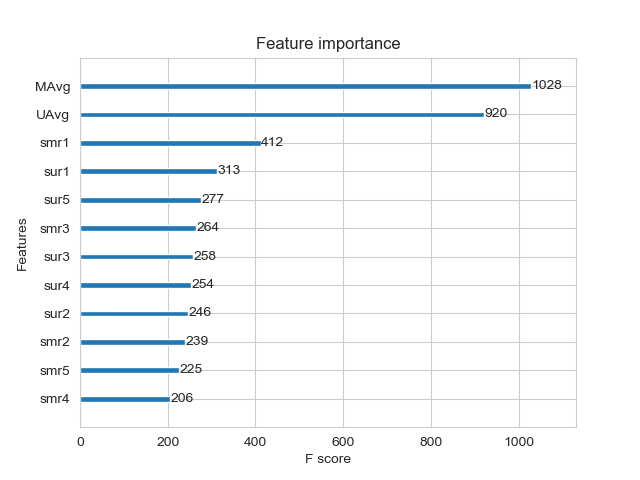

In [10]:
# traning using best hyperparameter
print("best_hyperparameter:",{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05},"\n\n")


# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


train_results, test_results = run_xgboost_hyperparameter_tune(xgb_model, x_train, y_train, x_test, y_test,verbose=1)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['initial 13 features'] = train_results 
models_evaluation_test['initial 13 features'] = test_results

xgb.plot_importance(xgb_model)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [12]:
from surprise import BaselineOnly 

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

#### Method : "als"

In [48]:
# creating hyperparameter alias

options=[]

epoch=[10,20,30,50]
n_user=[2,5,10,12,15]
n_item=[2,5,10,12,15]


for ep in epoch:
    for user in n_user:
        for item in n_item:  
            options.append({'method': 'als',
                           'n_epochs': ep,
                           'reg_u': item,
                           'reg_i': user
                           })

#example
print("bsl_option 1: ",options[0])

bsl_option 1:  {'method': 'als', 'n_epochs': 10, 'reg_u': 2, 'reg_i': 2}


In [67]:
# Traning 
train_rmse=[]
train_mape=[]
test_rmse=[]
test_mape=[]

for idx,param in enumerate(options):
    
    bsl_algo = BaselineOnly(bsl_options=param)
    # run this algorithm.., It will return the train and test results..
    print("index =",idx+1," out of" ,len(options), "completed")
    bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=False)

    # Just store these error metrics in our models_evaluation datastructure
    train_rmse.append(bsl_train_results['rmse']) 
    train_mape.append(bsl_train_results['mape'])
    
    test_rmse.append(bsl_test_results['rmse']) 
    test_mape.append(bsl_test_results['mape'])

    

index = 1  out of 100 completed
Estimating biases using als...
index = 2  out of 100 completed
Estimating biases using als...
index = 3  out of 100 completed
Estimating biases using als...
index = 4  out of 100 completed
Estimating biases using als...
index = 5  out of 100 completed
Estimating biases using als...
index = 6  out of 100 completed
Estimating biases using als...
index = 7  out of 100 completed
Estimating biases using als...
index = 8  out of 100 completed
Estimating biases using als...
index = 9  out of 100 completed
Estimating biases using als...
index = 10  out of 100 completed
Estimating biases using als...
index = 11  out of 100 completed
Estimating biases using als...
index = 12  out of 100 completed
Estimating biases using als...
index = 13  out of 100 completed
Estimating biases using als...
index = 14  out of 100 completed
Estimating biases using als...
index = 15  out of 100 completed
Estimating biases using als...
index = 16  out of 100 completed
Estimating biase

In [68]:
# storing reults of all the hyperparameter
result=pd.DataFrame({"param": options,"train_rmse":train_rmse,"train_mape":train_mape,"test_rmse":test_rmse,"test_mape":test_mape })
result

,param,train_rmse,train_mape,test_rmse,test_mape
0,"{'method': 'als', 'n_epochs': 10, 'reg_u': 2, ...",0.896630,27.336924,1.067473,34.228577
1,"{'method': 'als', 'n_epochs': 10, 'reg_u': 5, ...",0.899705,27.537338,1.067179,34.252275
2,"{'method': 'als', 'n_epochs': 10, 'reg_u': 10,...",0.904128,27.785690,1.067003,34.273143
3,"{'method': 'als', 'n_epochs': 10, 'reg_u': 12,...",0.905696,27.867779,1.066971,34.278442
4,"{'method': 'als', 'n_epochs': 10, 'reg_u': 15,...",0.907880,27.978513,1.066943,34.285001
...,...,...,...,...,...
95,"{'method': 'als', 'n_epochs': 50, 'reg_u': 2, ...",0.898681,27.506804,1.066728,34.354359
96,"{'method': 'als', 'n_epochs': 50, 'reg_u': 5, ...",0.901799,27.718905,1.066425,34.319823
97,"{'method': 'als', 'n_epochs': 50, 'reg_u': 10,...",0.906238,27.971642,1.066298,34.308159
98,"{'method': 'als', 'n_epochs': 50, 'reg_u': 12,...",0.907808,28.054399,1.066284,34.307193


In [69]:
best_result=result[result["test_mape"]==min(result["test_mape"])]
print(f"best parameter: {best_result['param'][0]}")
print(f"best RMSE_score: {best_result['test_rmse'][0]}")
print(f"best MAPE_score: {best_result['test_mape'][0]}")


best parameter: {'method': 'als', 'n_epochs': 10, 'reg_u': 2, 'reg_i': 2}
best RMSE_score: 1.0674729813270976
best MAPE_score: 34.22857744546804


#### Traning with best hyperparameter

In [14]:
# traning using best hyperparameter

print("traning using optimal hyperparameter: {'method': 'als', 'n_epochs': 10, 'reg_u': 2, 'reg_i': 2} \n\n")

bsl_algo = BaselineOnly( bsl_options={'method': 'als', 'n_epochs': 10, 'reg_u': 2, 'reg_i': 2})

# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)
    
# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

traning using optimal hyperparameter: {'method': 'als', 'n_epochs': 10, 'reg_u': 2, 'reg_i': 2} 


Estimating biases using als...
---------------
Train Data
---------------
RMSE : 0.8966304838554658

MAPE : 27.336923805931296

adding train results in the dictionary..
---------------
Test Data
---------------
RMSE : 1.0674729813270976

MAPE : 34.22857744546804

storing the test results in test dictionary...


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [15]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,174683,10,3.586697,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.733333,5,3.976859
1,233949,10,3.586697,4.0,4.0,5.0,1.0,5.0,2.0,3.0,3.0,3.0,3.0,2.692308,3.733333,3,3.930416


__Updating Test Data__

In [16]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(5)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.586697
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.586697
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.586697
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.586697
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.586697


#### Finding best hyperparameter 

In [103]:
from sklearn.model_selection import RandomizedSearchCV

# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


depth=[3,5,10,25,30,35]
learning_rate= [0.01,0.03,0.05,0.1,0.5,1]
n_estimators= [25,50,100,150,200]    

param={"max_depth":depth,"learning_rate":learning_rate,"n_estimators":n_estimators}


xgb_model=xgb.XGBRegressor(max_depth=3,learning_rate=0.1, n_estimators=100)

start =datetime.now()
# fit the model
print('Training the model..')
rscv=RandomizedSearchCV( estimator=xgb_model,param_distributions=param,scoring='neg_mean_squared_error',n_jobs=-2)
rscv.fit(x_train, y_train)
print('Done. Time taken : {}\n'.format(datetime.now()-start))
print('Done \n')




Training the model..
[18:10:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:19:07.183473

Done 



In [104]:
# best RMSE score
np.sqrt(-rscv.best_score_)

0.862558929050448

In [105]:
# best esitmator
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [106]:
rscv.best_params_

{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

#### Traning with best hyperparameter

traning using best_hyperparameter:{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}


Training the model..
[19:50:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:02:08.409808

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0749056674390538
MAPE :  34.63908028573338


<IPython.core.display.Javascript object>


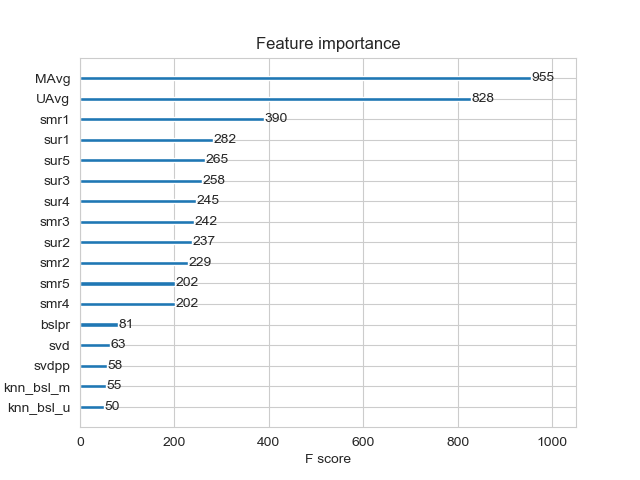

In [55]:
# traning using best hyperparameter
print("traning using best_hyperparameter:{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}\n\n")


# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

train_results, test_results = run_xgboost_hyperparameter_tune(xgb_model, x_train, y_train, x_test, y_test,verbose=1)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['13 features+bsl_m'] = train_results 
models_evaluation_test['13 features+bsl_m'] = test_results

xgb.plot_importance(xgb_model)
plt.show()



<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [20]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 

- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

#### Hyperparameter Tuning

In [145]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
# Traning 
train_rmse=[]
train_mape=[]
test_rmse=[]
test_mape=[]


k_range=[10,20,30,40,50]

for i in tqdm(range(len(k_range))):
    
    sim_options = {'user_based' : True,
                   'name': 'pearson_baseline',
                   'shrinkage': 100,
                   'min_support': 2
                  } 
    # we keep other parameters like regularization parameter and learning_rate as default values.
    bsl_options = {'method': 'sgd'} 

    knn_bsl_u = KNNBaseline(k=k_range[i], sim_options = sim_options, bsl_options = bsl_options)

    knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=False)
    # run this algorithm.., It will return the train and test results..
    print("index =",i+1," out of" ,len(options), "completed")

    # Just store these error metrics in our models_evaluation datastructure
    train_rmse.append(knn_bsl_u_train_results['rmse']) 
    train_mape.append(knn_bsl_u_train_results['mape'])
    
    test_rmse.append(knn_bsl_u_test_results['rmse']) 
    test_mape.append(knn_bsl_u_test_results['mape'])





  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
index = 2  out of 105 completed




 20%|████████████████                                                                | 1/5 [18:59<1:15:59, 1139.96s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
index = 2  out of 105 completed




 40%|████████████████████████████████▊                                                 | 2/5 [38:29<57:26, 1148.73s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
index = 2  out of 105 completed




 60%|█████████████████████████████████████████████████▏                                | 3/5 [58:19<38:42, 1161.35s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
index = 2  out of 105 completed




 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:18:44<19:40, 1180.24s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
index = 2  out of 105 completed




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:39:35<00:00, 1195.10s/it]


In [146]:
# storing reults of all the hyperparameter
result_knn_baseline=pd.DataFrame({"k": k_range,"train_rmse":train_rmse,"train_mape":train_mape,"test_rmse":test_rmse,"test_mape":test_mape })
result_knn_baseline

,k,train_rmse,train_mape,test_rmse,test_mape
0,10,0.314136,8.613099,1.065704,34.439241
1,20,0.390270,10.909957,1.065758,34.440028
2,30,0.428351,12.073307,1.065712,34.441516
3,40,0.452366,12.810295,1.065735,34.443225
4,50,0.469137,13.327551,1.065755,34.443847


In [147]:
best_result=result_knn_baseline[result_knn_baseline["test_mape"]==min(result_knn_baseline["test_mape"])]
print(f"best k: {result_knn_baseline['k'][0]}")
print(f"best RMSE_score: {result_knn_baseline['test_rmse'][0]}")
print(f"best MAPE_score: {result_knn_baseline['test_mape'][0]}")


best k: 10
best RMSE_score: 1.0657042125048963
best MAPE_score: 34.439241286194736


#### Traning Using best Hyperparameter

In [21]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=10, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.3141357816682863

MAPE : 8.613099315403797

adding train results in the dictionary..
---------------
Test Data
---------------
RMSE : 1.0657042125048963

MAPE : 34.439241286194736

storing the test results in test dictionary...


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [22]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.50085847421266

MAPE : 14.072064728120523

adding train results in the dictionary..
---------------
Test Data
---------------
RMSE : 1.066402047909581

MAPE : 34.45353435356671

storing the test results in test dictionary...


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

- - - First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.

 
- - - Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model. 

__Preparing Train data __

In [23]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,174683,10,3.586697,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.733333,5,3.976859,4.993203,4.889383
1,233949,10,3.586697,4.0,4.0,5.0,1.0,5.0,2.0,3.0,3.0,3.0,3.0,2.692308,3.733333,3,3.930416,3.164466,3.282333


__Preparing Test data  __

In [24]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.586697,3.586697,3.586697
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.586697,3.586697,3.586697


In [25]:
# pickle saving

import pickle 
'''file = open('reg_update_train.pkl', 'wb') 
pickle.dump(reg_train, file)

import pickle 
file = open('reg_update_test.pkl', 'wb') 
pickle.dump(reg_test_df, file)
'''

file = open('reg_update_train.pkl', 'rb') 
reg_train=pickle.load(file)

file = open('reg_update_test.pkl', 'rb') 
reg_test_df=pickle.load(file)

#### Hyperparameter Tuning 

In [156]:
from sklearn.model_selection import RandomizedSearchCV

# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


depth=[3,5,10,25,30,35]
learning_rate= [0.01,0.03,0.05,0.1,0.5,1]
n_estimators= [25,50,100,150,200]    

param={"max_depth":depth,"learning_rate":learning_rate,"n_estimators":n_estimators}


xgb_model=xgb.XGBRegressor(max_depth=3,learning_rate=0.1, n_estimators=100)

start =datetime.now()
# fit the model
print('Training the model..')
rscv=RandomizedSearchCV( estimator=xgb_model,param_distributions=param,scoring='neg_mean_squared_error',n_jobs=-2)
rscv.fit(x_train, y_train)
print('Done. Time taken : {}\n'.format(datetime.now()-start))
print('Done \n')




Training the model..
[22:08:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:29:53.364050

Done 



In [157]:
# best RMSE score
np.sqrt(-rscv.best_score_)

0.8629562063851135

In [158]:
# best esitmator
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [159]:
rscv.best_params_

{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}

#### Traning using best hyperparameter

traning using best_hyperparameter:{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}


Training the model..
[19:53:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:05:56.092928

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1491717436917956
MAPE :  32.22357687735982


<IPython.core.display.Javascript object>


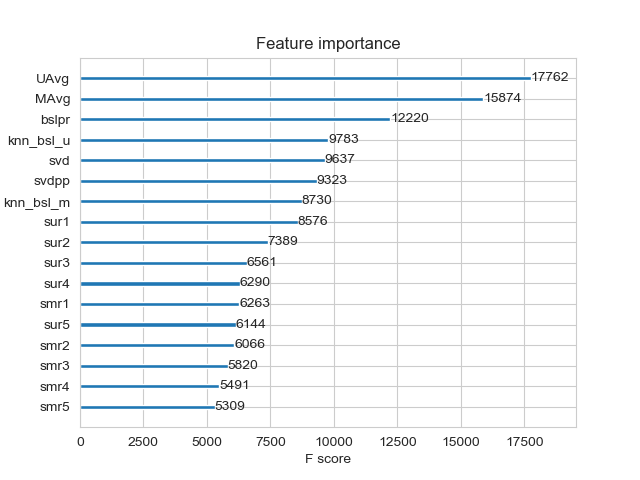

In [57]:
# traning using best hyperparameter
print("traning using best_hyperparameter:{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}\n\n")


# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

train_results, test_results = run_xgboost_hyperparameter_tune(xgb_model, x_train, y_train, x_test, y_test,verbose=1)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['13 features+bsl_m+knn_bsl_m'] = train_results 
models_evaluation_test['13 features+bsl_m+knn_bsl_m'] = test_results

xgb.plot_importance(xgb_model)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [30]:
from surprise import SVD

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


- A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [31]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
---------------
Train Data
---------------
RMSE : 0.6724095459788582

MAPE : 20.00557612865896

adding train results in the dictionary..
---------------
Test Data
---------------
RMSE : 1.0658291640505728

MAPE : 34.32164154476558

storing the test results in test dictionary...


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [32]:
from surprise import SVDpp

- ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [33]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
---------------
Train Data
---------------
RMSE : 0.6630297928023139

MAPE : 19.2061856855646

adding train results in the dictionary..
---------------
Test Data
---------------
RMSE : 1.0665294257919915

MAPE : 34.20534945513256

storing the test results in test dictionary...


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [34]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.586697,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.733333,5,3.976859,4.993203,4.889383,3.892297,4.079974
1,233949,10,3.586697,4.0,4.0,5.0,1.0,5.0,2.0,3.0,...,3.0,3.0,2.692308,3.733333,3,3.930416,3.164466,3.282333,3.709441,3.702948


__Preparing Test data  __

In [35]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.586697,3.586697,3.586697,3.586697,3.586697
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.586697,3.586697,3.586697,3.586697,3.586697


In [36]:
# pickle saving

"""import pickle 
file = open('reg_update_train.pkl', 'wb') 
pickle.dump(reg_train, file)

import pickle 
file = open('reg_update_test.pkl', 'wb') 
pickle.dump(reg_test_df, file)
"""

file = open('reg_update_train.pkl', 'rb') 
reg_train=pickle.load(file)

file = open('reg_update_test.pkl', 'rb') 
reg_test_df=pickle.load(file)

#### HyperParameter Tuning usning RandomSearchCV

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


depth=[3,5,10,25,30,35]
learning_rate= [0.01,0.03,0.05,0.1,0.5,1]
n_estimators= [25,50,100,150,200]    

param={"max_depth":depth,"learning_rate":learning_rate,"n_estimators":n_estimators}


xgb_model=xgb.XGBRegressor(max_depth=3,learning_rate=0.1, n_estimators=100)

start =datetime.now()
# fit the model
print('Training the model..')
rscv=RandomizedSearchCV( estimator=xgb_model,param_distributions=param,scoring='neg_mean_squared_error',n_jobs=-2)
rscv.fit(x_train, y_train)
print('Done. Time taken : {}\n'.format(datetime.now()-start))
print('Done \n')




Training the model..
[17:58:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:27:01.263794

Done 



In [38]:
# best RMSE score
np.sqrt(-rscv.best_score_)

0.8626559746121821

In [23]:
# best esitmator
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
rscv.best_params_

{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

#### Traning with best hyperparameter

Training the model..
[18:01:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:02:09.770045

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0749056674390538
MAPE :  34.63908028573338


<IPython.core.display.Javascript object>


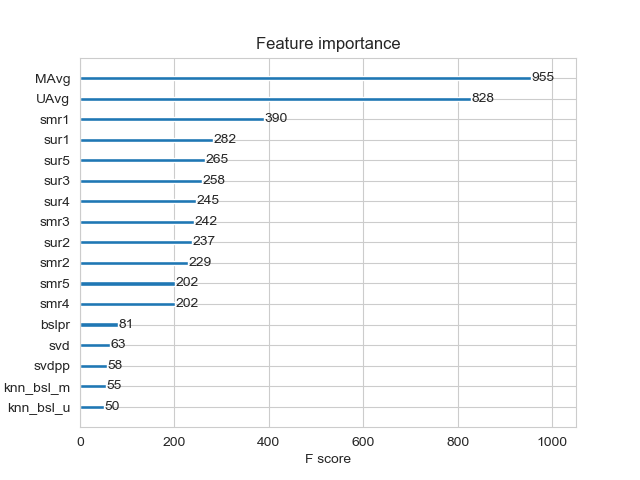

In [40]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = rscv.best_estimator_

train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

#### Hyperparameter Tuning

In [41]:
from sklearn.model_selection import RandomizedSearchCV

# prepare Train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


depth=[3,5,10,25,30,35]
learning_rate= [0.01,0.03,0.05,0.1,0.5,1]
n_estimators= [25,50,100,150,200]    

param={"max_depth":depth,"learning_rate":learning_rate,"n_estimators":n_estimators}


xgb_model=xgb.XGBRegressor(max_depth=3,learning_rate=0.1, n_estimators=100)

start =datetime.now()
# fit the model
print('Training the model..')
rscv=RandomizedSearchCV( estimator=xgb_model,param_distributions=param,scoring='neg_mean_squared_error',n_jobs=-2)
rscv.fit(x_train, y_train)
print('Done. Time taken : {}\n'.format(datetime.now()-start))
print('Done \n')




Training the model..
[18:15:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:12:44.939846

Done 



In [42]:
# best RMSE score
np.sqrt(-rscv.best_score_)

1.083152058523289

In [43]:
# best esitmator
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [44]:
rscv.best_params_

{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}

#### Traning using optimal hyperparameter

Training the model..
[18:16:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:49.278826

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.075420477871072
MAPE :  35.21831995221971


<IPython.core.display.Javascript object>


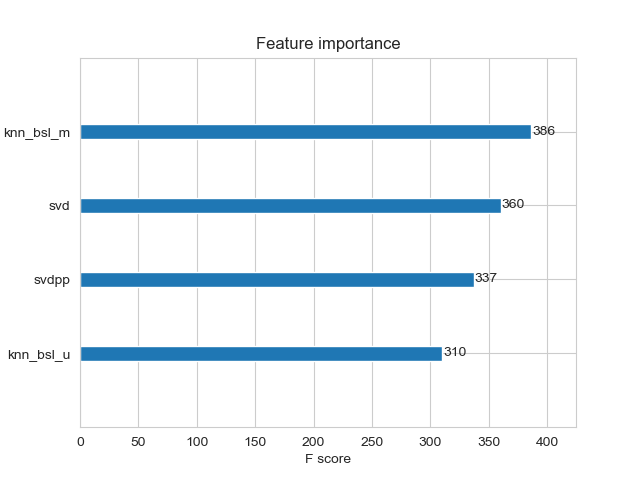

In [45]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = rscv.best_estimator_
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h2> 4.5 Comparision between all models </h2>

### 4.5.1 Before Hypertuning

In [91]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
models = pd.read_csv('sample/small/small_sample_results.csv', index_col=0)


In [105]:
models.T[["rmse",'mape']].sort_values(by='rmse')

,rmse,mape
knn_bsl_u,1.0657348797314812,34.44322466866583
svd,1.0658291640505728,34.32164154476558
bsl_algo,1.0659638954236386,34.43052499512186
knn_bsl_m,1.066402047909581,34.45353435356671
svdpp,1.0665294257919915,34.20534945513256
first_algo,1.0731831625477235,34.93936012439215
xgb_bsl,1.0731848133115496,34.93942495443435
xgb_knn_bsl,1.0731848133115496,34.93942495443435
xgb_final,1.0731851944485837,34.939430765230185
xgb_all_models,1.0753710007379194,35.2152699422574


### 1.5.2 After Hypertuning

In [106]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('sample/small/small_sample_results_new.csv')
models_new = pd.read_csv('sample/small/small_sample_results_new.csv', index_col=0)

In [116]:
(models_new.iloc[:2].T.sort_values(by='rmse'))

,rmse,mape
knn_bsl_u,1.0657042125048963,34.439241286194736
svd,1.0658291640505728,34.32164154476558
knn_bsl_m,1.066402047909581,34.45353435356671
svdpp,1.0665294257919915,34.20534945513256
bsl_algo,1.0674729813270976,34.22857744546804
xgb_final,1.0749056674390538,34.63908028573338
initial 13 features,1.0749056674390538,34.63908028573338
13 features+bsl_m,1.0749056674390538,34.63908028573338
xgb_all_models,1.075420477871072,35.21831995221971
13 features+bsl_m+knn_bsl_m,1.1491717436917956,32.22357687735982


Observation:
    
There is very slight improvement is RMSE after hypertuning. This could be because of choosing only 25k user and 3k movies_item as traning data.



### END :)